The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


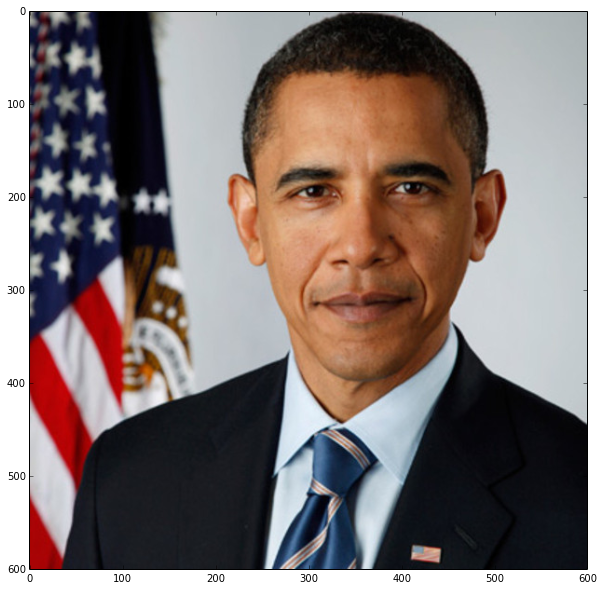

time: 468 ms


In [2]:
%matplotlib inline
%load_ext autotime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math




img = cv2.imread('obama.jpg', 1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_rgb)


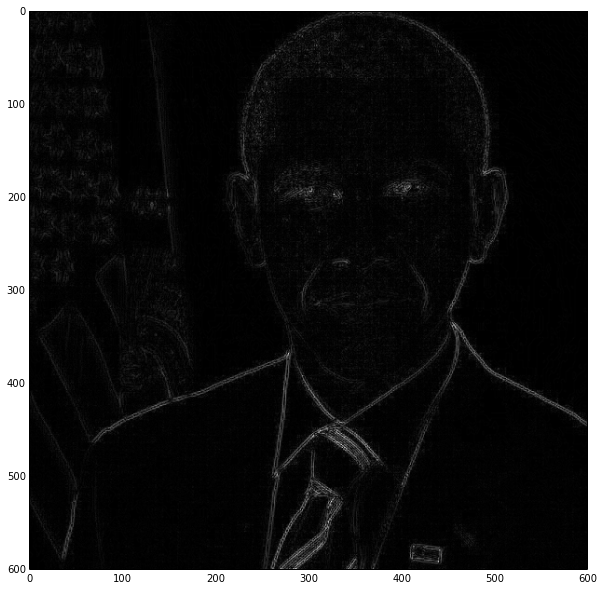

time: 386 ms


In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

laplacian = np.abs(cv2.Laplacian(gray,  cv2.CV_64F))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(laplacian, cmap='gray')  

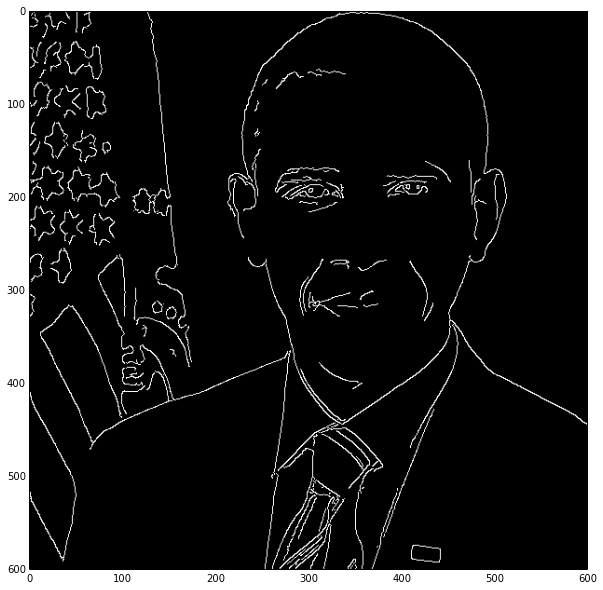

time: 246 ms


In [4]:
blurred = cv2.medianBlur(gray, 3)
v = np.median(blurred)
sigma = 0.6
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(blurred, 100, 200)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(edges, cmap='gray')  

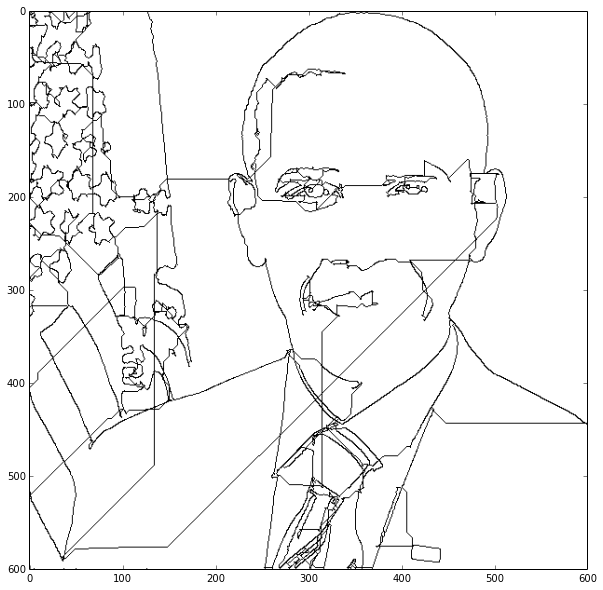

time: 45.2 s


In [13]:
import heapq

def reconstruct(current, came_from):
    path = [current]
    while current in came_from.keys():
        current = came_from[current]
        path.insert(0, current)
    return path
        

def nearest(start, used, edges, costimg):
    queue = [(0, start)]
    gscore = np.zeros_like(costimg) + float('inf')
    gscore[start] = 0
    node = None
    came_from = {}
    while True:
        if len(queue) == 0:
            return False
        cost, node = heapq.heappop(queue)
        if node not in used and edges[node] == 255:
            break
        (i, j) = node
        for (k, l) in [(i+1, j), (i-1, j), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1), (i, j+1), (i, j-1)]:
            if 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1]:
                new_g = cost + (1 if i == k or j == l else 1.414)
                if new_g < gscore[k, l]:
                    gscore[k, l] = new_g
                    heapq.heappush(queue, (new_g, (k, l)))
                    came_from[(k, l)] = (i, j)
    return reconstruct(node, came_from)

def nn_ts(start, edges, costimg):
    path = [start]
    used = set([start])
    city_count = 1 if edges[start] == 0 else 0
    city_n = np.sum(edges == 255)
    while city_count < city_n:
        i, j = path[-1]
        found = False
        for (k, l) in [(i+1, j), (i-1, j), (i, j+1), (i, j-1), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1)]:
            if 0 <= k < costimg.shape[0] and 0 <= l < costimg.shape[1] and (k, l) not in used and edges[k, l] == 255:
                path.append((k, l))
                used.add((k, l))
                found = True
                city_count += 1
                break
        if not found:
            sub_path = nearest((k, l), used, edges, costimg)
            if not sub_path:
                print 'here'
                return path
            path.extend(sub_path)
            used.add(path[-1])
            city_count += 1
    return path

costimg = 1/(laplacian + 1) * 10
costimg[edges == 255] = 0
path = nn_ts((0, 0), edges, costimg)

# path = nearest((500, 50), set(), edges, costimg)
path = np.array(path)
result = np.ones_like(edges) * 255
result[path[:, 0], path[:, 1]] = 0

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(result, cmap='gray')  

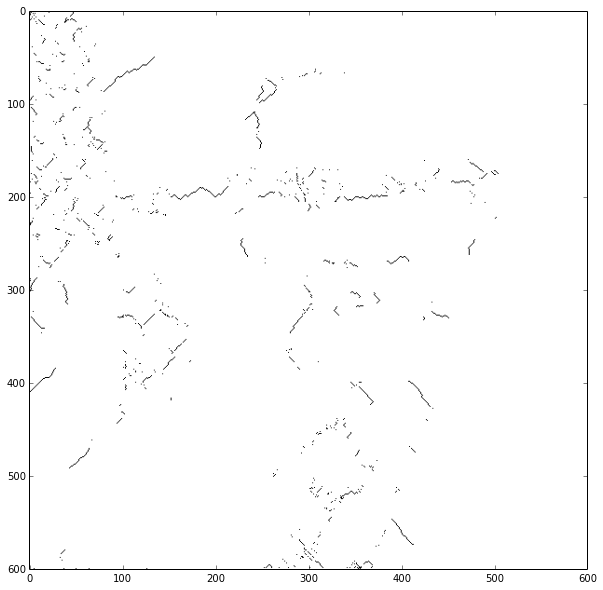

time: 284 ms


In [6]:
diff = np.copy(result)
diff[edges == 255] = 255
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(diff, cmap='gray') 

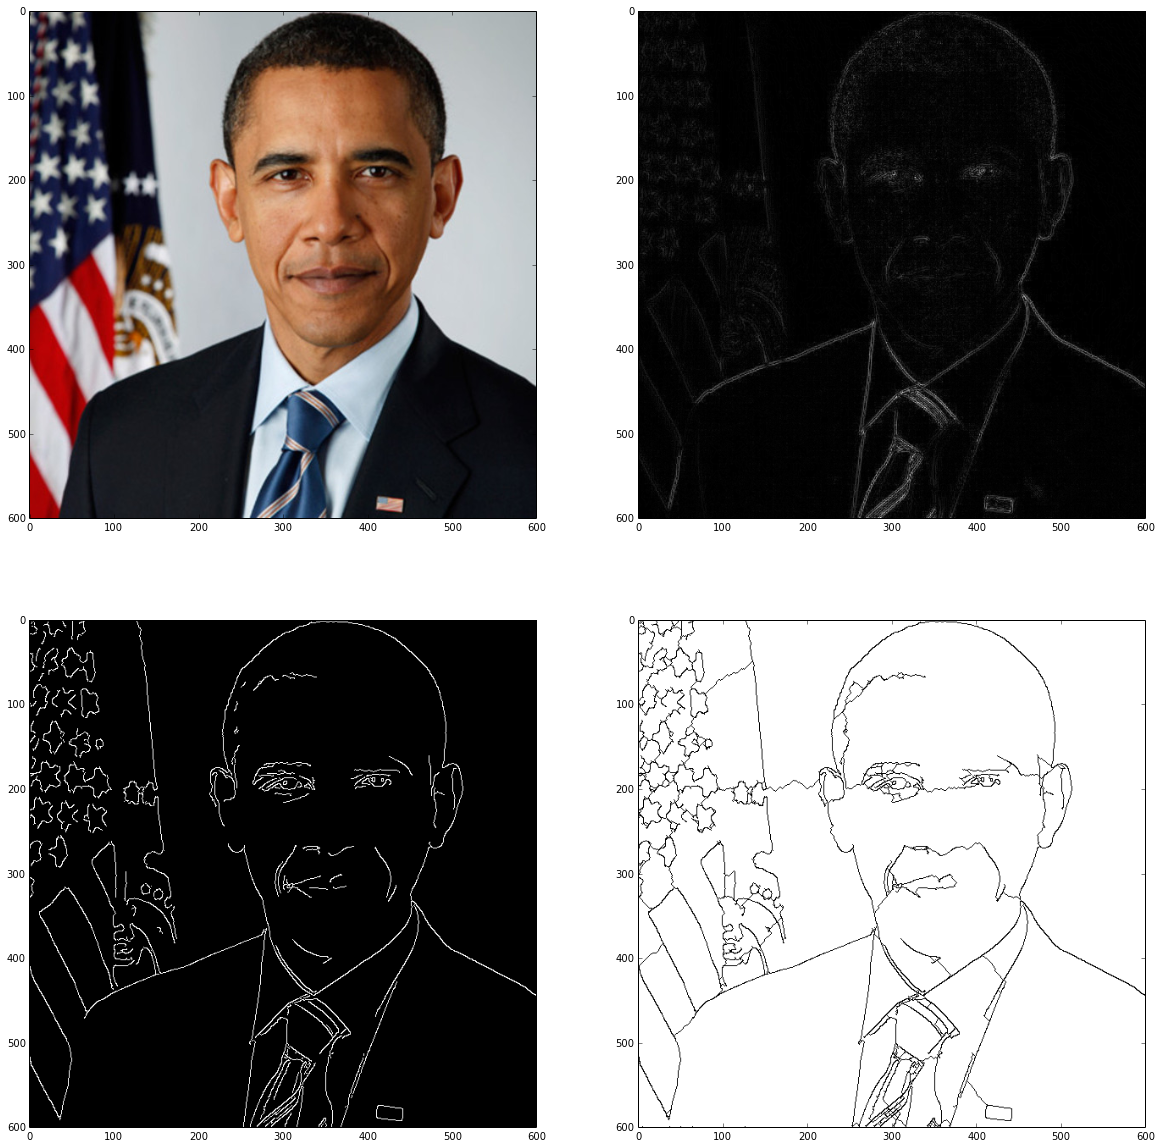

time: 1.19 s


In [7]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(img_rgb, cmap='gray') 
ax[0, 1].imshow(laplacian, cmap='gray') 
ax[1, 0].imshow(edges, cmap='gray') 
ax[1, 1].imshow(result, cmap='gray') 

In [8]:
result[result==255].size

347365

time: 4.34 ms
